In [30]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
x = dados[['preco','idade_do_modelo','km_por_ano']]

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


# Situação horrivel de 'azar' onde as classes estão ordenadas por padrão


In [31]:
dados_azar = dados.sort_values('vendido', ascending=True)
x_azar = dados_azar[['preco','idade_do_modelo','km_por_ano']]
y_azar = dados_azar['vendido']
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


# Utilizando o DummyClassifier com os dados ordenados para baseline

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np
import warnings
warnings.filterwarnings('ignore')

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print('Acurácia co dummy statified, 10 = [%.2f, %.2f]' % ((media-2*desvio_padrao)*100,((media+2*desvio_padrao)*100)))

Acurácia co dummy statified, 10 = [49.79, 53.45]


# Utilizando o DecisionTreeClassifier com os dados ordenados para baseline

In [33]:
from sklearn.tree import DecisionTreeClassifier
SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print('Acurácia co dummy statified, 10 = [%.2f, %.2f]' % ((media-2*desvio_padrao)*100,((media+2*desvio_padrao)*100)))

Acurácia co dummy statified, 10 = [68.67, 75.71]


# Gerando dados aleatórios do modelo de carro para simulação de agrupamento ao usar nosso estimador

In [34]:
np.random.seed(SEED)

dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2,3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1 
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [35]:
def imprime_resultados(results):
    media = results['test_score'].mean()*100
    desvio = results['test_score'].std()*100
    print('Acurácia média %.2f' % media)
    print('Intervalo [%.2f, %.2f]' % (media-2 *desvio, media+2*desvio))

# GroupKFold para analisar como o modelo se comporta com novos grupos

In [36]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 75.78
Intervalo [73.67, 77.90]


In [37]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler),('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv , groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 76.68
Intervalo [74.28, 79.08]


In [39]:
import graphviz
from sklearn.tree import export_graphviz

"""modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True,
                rounded = True,
                class_names = ['não','sim'])
                #feature_names = features)

# Temos 10 modelos (cv = 10)
graph = graphviz.Source(dot_data)
graph"""

AttributeError: 'SVC' object has no attribute 'tree_'

In [40]:
cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 77.20
Intervalo [75.35, 79.05]


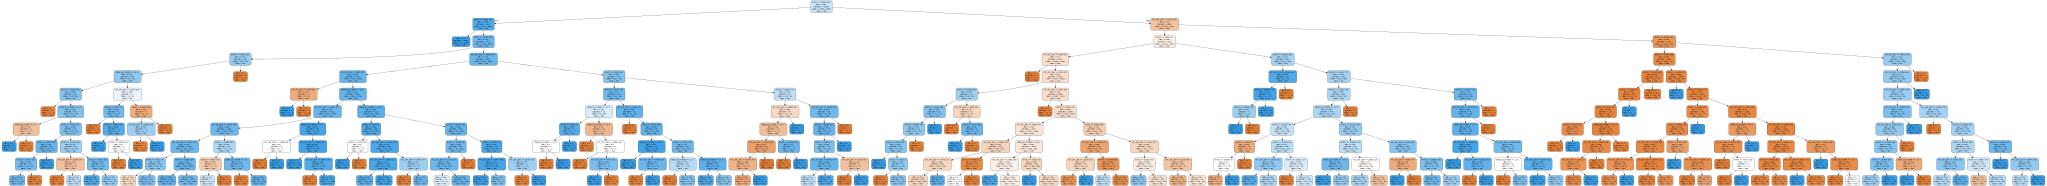

In [41]:
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True,
                rounded = True,
                class_names = ['não','sim'],
                feature_names = features)

# Temos 10 modelos (cv = 10)
graph = graphviz.Source(dot_data)
graph

# Testando parâmetros

In [42]:
def roda_arvore_de_descisao(max_depth):
    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth = max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    #print('max_depth = %d, media treino = %.2f , media teste = %.2f' % (max_depth, train_score,test_score))
    tabela = [max_depth, train_score, test_score]
    return tabela
resultados = [roda_arvore_de_descisao(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.545962


# Explorando hiperparêmtros em 1 dimensão -> Deu certo para dar errado -> Overfit

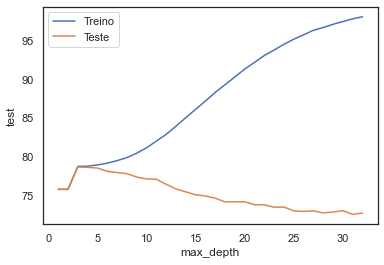

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = 'max_depth',y='train', data=resultados)
sns.lineplot(x = 'max_depth',y='test', data=resultados)
plt.legend(['Treino','Teste'])

In [44]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.545962
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiperparêmtros em 2 dimensões

In [45]:
def roda_arvore_de_descisao(max_depth,min_samples_leaf):
    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth = max_depth,min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    #print('max_depth = %d, media treino = %.2f , media teste = %.2f' % (max_depth, train_score,test_score))
    tabela = [max_depth,min_samples_leaf, train_score, test_score]
    return tabela
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32,64,128,256]:
            tabela =roda_arvore_de_descisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth",",min_samples_leaf", "train", "test"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,",min_samples_leaf",train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [46]:
resultados.sort_values('test',ascending=False).head()

,max_depth,",min_samples_leaf",train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [47]:
corr = resultados.corr()

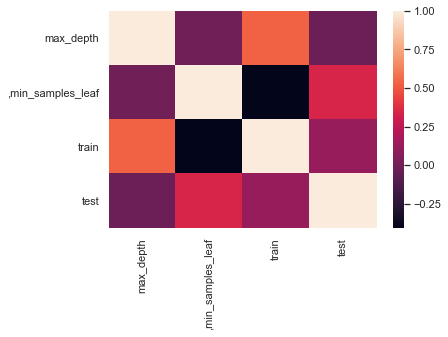

In [48]:
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0AD820A0>,
      dtype=object)

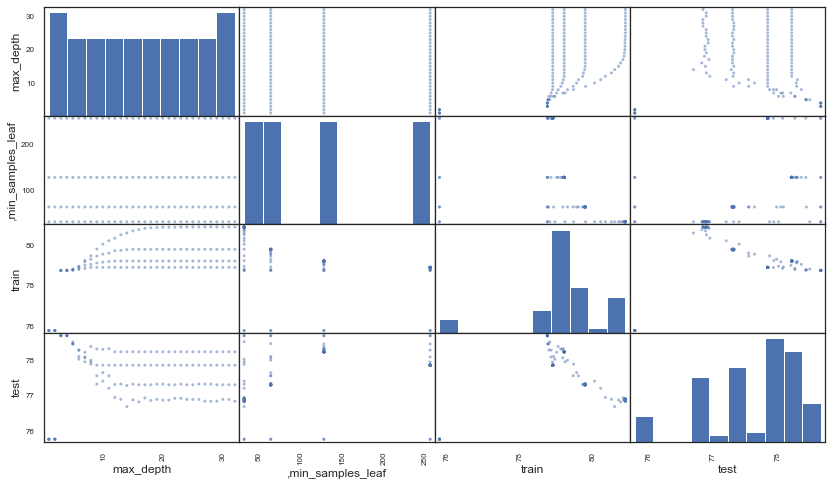

In [49]:
from pandas.plotting import scatter_matrix

scatter_matrix(resultados,figsize=(14,8))

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

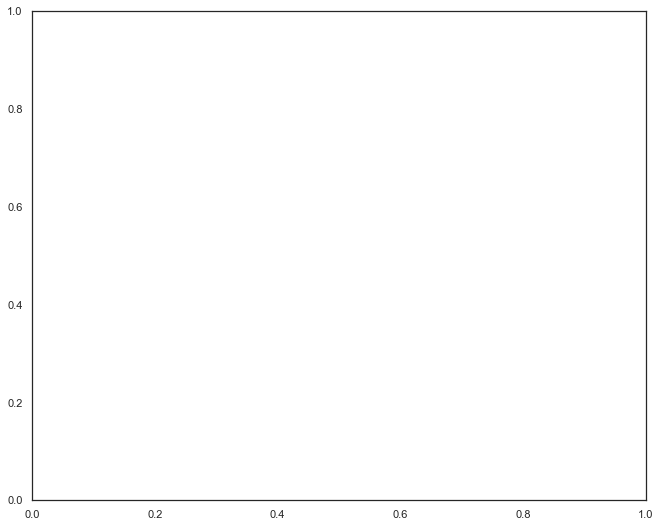

In [50]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando três dimensões

In [51]:
def roda_arvore_de_descisao(max_depth,min_samples_leaf,min_samples_split):
    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth = max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    #print('max_depth = %d, media treino = %.2f , media teste = %.2f' % (max_depth, train_score,test_score))
    tabela = [max_depth,min_samples_leaf, train_score, test_score,min_samples_split]
    return tabela
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32,64,128,256]:
            for min_samples_split in [32,64,128,256]:
                tabela =roda_arvore_de_descisao(max_depth, min_samples_leaf,min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth",",min_samples_leaf", "train", "test","min_samples_split"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,",min_samples_leaf",train,test,min_samples_split
0,1,32,75.791169,75.784219,32
1,1,32,75.791169,75.784219,64
2,1,32,75.791169,75.784219,128
3,1,32,75.791169,75.784219,256
4,1,64,75.791169,75.784219,32


In [52]:
resultados.sort_values('test',ascending=False).head()

,max_depth,",min_samples_leaf",train,test,min_samples_split
63,4,256,78.750993,78.672633,256
48,4,32,78.750993,78.672633,32
34,3,32,78.750993,78.672633,128
35,3,32,78.750993,78.672633,256
36,3,64,78.750993,78.672633,32


TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

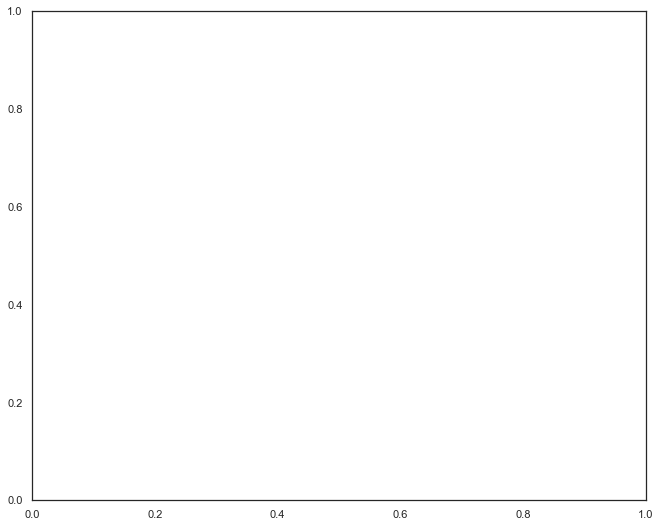

In [53]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Explorando espaço de hiperparâmentros com GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

In [ ]:
busca.best_params_

In [ ]:
busca.best_score_

In [ ]:
busca.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score 

predicoes = busca.best_estimator_.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

cuidado de usar cross validation com hiperparâmetros, pois há vários modelos em testes.Evitar essa abordagem, pois ela é otimista.

# Como ter uma estimativa sem esse vício nos dados que eu já vi?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

# Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultados para novos grupos

In [ ]:
from sklearn.model_selection import GridSearchCV,KFold

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

In [ ]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits = 5, shuffle=True))
score

In [ ]:
def imprime_resultados(results):
    media = results.mean()*100
    desvio = results.std()*100
    print('Acurácia média %.2f' % media)
    print('Intervalo [%.2f, %.2f]' % (media-2 *desvio, media+2*desvio))

In [ ]:
imprime_resultados(score)

In [ ]:
melhor = busca.best_estimator_
melhor

In [ ]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,KFold

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16 ,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

In [ ]:
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle = True))
imprime_resultados(scores)

In [ ]:
melhor = busca.best_estimator_
print(melhor)

# Customizando o espaço de hiperparâmetros

In [ ]:
from scipy.stats import randint

espaco_de_parametros = {
    "max_depth" : [3, 5,10,15,20,30],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16 ,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados

In [ ]:
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle = True))
imprime_resultados(scores)
melhor = busca.best_estimator_
print(melhor)

In [ ]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score',ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

# Uma exploração mais afundo da forma aleatória

In [ ]:
espaco_de_parametros = {
    "max_depth" : [3, 5,10,15,20,30],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 64 ,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

In [ ]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score',ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

In [ ]:
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle = True))
imprime_resultados(scores)
melhor = busca.best_estimator_
print(melhor)

# Comparando GridSearchCV com RandomizedSearch (1 comparação)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# ensemble RandomForestClassifier -> testa vários tipos de árvores
import time

espaco_de_parametros = {
    "n_estimators" : [10,100],
    "max_depth" : [3, 5,10,15,20,30],
    "min_samples_split": [32,64, 128],
    "min_samples_leaf": [32,64 ,128],
    "bootstrap" : [True,False],
    "criterion": ["gini", "entropy"]

}

tic  = time.time()

busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
tac = time.time()


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
print(" %.2f segundos" % (tac-tic))
resultados.head()

In [ ]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score',ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle = True))
tac = time.time()
print("%.2f segundos"%(tac-tic))

imprime_resultados(scores)
melhor = busca.best_estimator_
print(melhor)

In [ ]:
espaco_de_parametros = {
    "n_estimators" : [10,100],
    "max_depth" : [3, 5],
    "min_samples_split": [32,64, 128],
    "min_samples_leaf": [32,64 ,128],
    "bootstrap" : [True,False],
    "criterion": ["gini", "entropy"]

}

tic  = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
tac = time.time()


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
print(" %.2f segundos" % (tac-tic))
resultados.head()

In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle = True))
tac = time.time()
print("%.2f segundos"%(tac-tic))

imprime_resultados(scores)
melhor = busca.best_estimator_
print(melhor)

Portanto, observe que o RandomizedSearchCV você poderá ter um controle sobre o tempo de processamento 
dos modelos, pois pode-se alterar com o parâmetro n_iter.

# Se eu não posso ou não consigo usar cross validation

In [ ]:
# 0.6 treino    => treino
# 0.2 teste     => dev teste
# 0.2 validação => validacao

from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar,
                                                                            test_size=0.2,shuffle=True)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" : [10,100],
    "max_depth" : [3, 5],
    "min_samples_split": [32,64, 128],
    "min_samples_leaf": [32,64 ,128],
    "bootstrap" : [True,False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits= 1, text_size = 0.25)


tic  = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = KFold(n_splits = 5, shuffle=True))
tac = time.time()


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
print(" %.2f segundos" % (tac-tic))
resultados.head()

In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv=split)
tac = time.time()
print("%.2f segundos"%(tac-tic))

imprime_resultados(scores)
melhor = busca.best_estimator_
print(melhor)